# Golf Play Dataset - Decision Tree
**Technique:** Decision Trees<br>
**Guiding Documentation:** "Data Science: Concepts and Practice" - Kotu/Deshpande Chapter 4.1 (Book: [amazon](https://www.amazon.ca/Predictive-Analytics-Data-Mining-Concepts/dp/012814761X) [official](http://www.introdatascience.com/))<br>
- **Goal:** reproduce results in chapter, learn effect of tuning parameters <br>
- **Process:** "4.1 Decision Trees - 4.1.2 How to Implement", paraphrasing:<br>
    1. **Read in data** (add: data **exploration**, **decision math** check)
    2. **Split data** into training, test samples (add: **pre-process after** splitting, see below!)
    3. **Build model** using training data
    4. **Evaluate model** using test data (8.1 Confusion Matrix)<br>
- Additional step for real-world application:
    5. Optimize model: **tuning parameters** (15.6 Optimization), **cross-validation**<br>
- Experiment: **discretize** numerical attributes

**Idea:** *Recursive partitioning*<br>
**Math:** Shannon's Entropy (h), Information Gain (IG)<br>
**Dataset(s):** Golf Play Dataset<br>
- (+) learn to explore and encode **categorical** attributes (outlook, wind)
- (-) **small** dataset (training samples = 14, test samples = 14), unbalanced classes (yes > no)<br>

**Python:** Pandas, [Scikit-learn "DecisionTreeClassifier"](https://scikit-learn.org/stable/modules/tree.html), reference my own code from **./iris_data_explore.ipynb**<br>
**Tuning Parameters (<):** decision math (IG, IG-ratio, Gini), pre/post-pruning STOP conditions<br>
**Advantages (+):** white box (explanatory), robust vs. missing/outlier/un-scaled data<br>
**Disadvantages (-):** **overfits** data if not pruning<br>
**Caveats (\*):**

The golf play dataset is known from the "ID3 algorithm" paper:
- Quinlan JR. Induction of decision trees. *Machine Learning*. 1986;1(1):81-106<br>

However, Quinlan doesn't actually mention "golf" specifically in his paper, just weather of "Saturday mornings", so I can imagine it's actually weather for tennis since that is more my sport!

## Import packages, functions, and classes
Import libraries:
- Data Science: NumPy, Pandas<br>
- Decision tree model: **Scikit-learn**<br>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math #needed for floor, ceil in plotting setup functions

#scikit-learn imports
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

#Output mode switching: show all or only "last expression" (default)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
#InteractiveShell.ast_node_interactivity = 'last_expr'

## 1. Read in and pre-process data
### Read from CSV
[Read in](https://realpython.com/lessons/importing-csv-data-pandas-dataframe/) the **Golf Play Dataset** into a Pandas [DataFrame](https://realpython.com/pandas-python-explore-dataset/#accessing-dataframe-elements).<br>
- using book versions of training (Table 4.1) and test (Figure 4.6) data:
    - numerical "temperature" and "humidity"
    - both datasets have 14 records
    - to compare with book results, initially keep these as distinct training and test samples 

Column names for attributes and class label are below.<br>
1. Outlook (category): sunny, overcast, rain
2. Temperature (numerical)
3. Humidity (numerical)
4. Wind (category): TRUE, FLASE
5. Play (class):
    - yes
    - no
    
**Note:**
- columns are in header row of CSV file

In [2]:
df_golf_train = pd.read_csv('./data/golf_training.csv')
df_golf_test =  pd.read_csv('./data/golf_test.csv')

df_golf_train.head(df_golf_train.shape[0])
df_golf_test.head(df_golf_test.shape[0])

,Outlook,Temperature,Humidity,Wind,Play
0,sunny,85,85,False,no
1,sunny,80,90,True,no
2,overcast,83,78,False,yes
3,rain,70,96,False,yes
4,rain,68,80,False,yes
5,rain,65,70,True,no
6,overcast,64,65,True,yes
7,sunny,72,95,False,no
8,sunny,69,70,False,yes
9,rain,75,80,False,yes


,Outlook,Temperature,Humidity,Wind,Play
0,sunny,85,85,False,yes
1,overcast,80,90,True,no
2,overcast,83,78,False,yes
3,rain,70,96,False,yes
4,rain,68,80,True,yes
5,rain,65,70,True,no
6,overcast,64,65,True,yes
7,sunny,72,95,False,no
8,sunny,69,70,False,yes
9,sunny,75,80,False,no


### Minor data preparation tasks
- Change column names to lowercase
- SKIP because will be encoding categorical data anyways for scikit-learn:
    - (Change strings to Pandas `category` [data type](https://realpython.com/pandas-python-explore-dataset/#specifying-data-types))
- Combine for data exploration and later, cross-validation
- Check [missing values](https://realpython.com/pandas-python-explore-dataset/#missing-values) (non-null from `info()`)

In [3]:
df_golf_train.columns = [column.lower() for column in df_golf_train.columns]
df_golf_test.columns = [column.lower() for column in df_golf_test.columns]

#df_golf_train['outlook'] = pd.Categorical(df_golf_train['outlook'])
#df_golf_train['play'] = pd.Categorical(df_golf_train['play'])

df_golf_all = pd.concat([df_golf_train, df_golf_test])
df_golf_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 0 to 13
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   outlook      28 non-null     object
 1   temperature  28 non-null     int64 
 2   humidity     28 non-null     int64 
 3   wind         28 non-null     bool  
 4   play         28 non-null     object
dtypes: bool(1), int64(2), object(2)
memory usage: 1.1+ KB


### Data exploration - Univariate: per-attribute by-class

Numerical attributes (temperature, humidity): show histogram<br>
**Categorical** attributes (outlook, wind): show bar chart<br>

**Python - Pandas:**
- Reference code: **iris_data_explore.ipynb**
- histogram binning arrays are different sizes so store in `dict` instead of `DataFrame`
- loop through attribute columns and depending on `dtype`: plot histogram or bar chart
- **bar chart** works differently than histogram:
    - calculate `value_counts()` as input to `plot.bar`
    - [reshape](https://pandas.pydata.org/docs/user_guide/reshaping.html) GroupBy object (multi-index) using `unstack()` to get `play` classes into columns!!

In [4]:
def histogram_bins(d_min=0, d_max=10, d_binw=0.5):
    """Setup histogram binning based on (d)ata inputs using NumPy to create list of bin edges
    
    Parameters
    ----------
    d_min : first bin left edge (default=0)
    d_max : last bin left edge (default=10)
    d_binw : bin width
    
    Returns
    -------
    histogram_bins : ndarray
        Bin edges for `bins` input of Pandas/Matplotlib histogram methods
        Note: last bin is [d_max, d_max+d_binw]"""
        
    return np.round_(np.arange(d_min, d_max+(2*d_binw), d_binw), decimals=1) #2*d_binw so max value gets own bin   

<AxesSubplot:title={'center':'outlook'}, xlabel='outlook'>

play
no     AxesSubplot(0.547727,0.536818;0.352273x0.343182)
yes    AxesSubplot(0.547727,0.536818;0.352273x0.343182)
Name: temperature, dtype: object

play
no     AxesSubplot(0.125,0.125;0.352273x0.343182)
yes    AxesSubplot(0.125,0.125;0.352273x0.343182)
Name: humidity, dtype: object

<AxesSubplot:title={'center':'wind'}, xlabel='wind'>

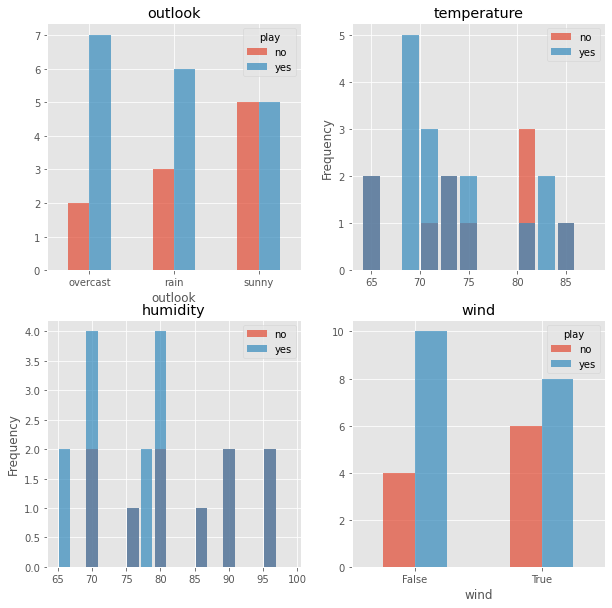

In [5]:
#create subplots: setup 2x2 Axes in one Figure 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

#Histogram binning per numerical column: (t)emperature, (h)umidity
t_tuple = (df_golf_all['temperature'].min(), df_golf_all['temperature'].max())
h_tuple = (df_golf_all['humidity'].min(), df_golf_all['humidity'].max())
bins = dict({'temperature': histogram_bins(d_min=t_tuple[0], d_max=t_tuple[1], d_binw=2),
             'humidity'   : histogram_bins(d_min=h_tuple[0], d_max=h_tuple[1], d_binw=2)})

columns = df_golf_all.columns.tolist()[0:-1] #all but last column 'play' (classes)
for idx, column in enumerate(columns):
    if (df_golf_all[column].dtype == np.int64):
        df_golf_all.groupby('play')[column].plot.hist(ax=axes[int(idx/2),idx%2],
                                                      bins=bins[column],
                                                      rwidth=0.85, alpha=0.7,
                                                      title=column, legend=True)
    else:
        df_golf_all.groupby('play')[column].value_counts().unstack('play').plot.bar(ax=axes[int(idx/2),idx%2],
                                                                                    rot=0, alpha=0.7,
                                                                                    title=column, legend=True)
#plt.savefig('images/golf_per_attribute_by_class.png')

**Observations**<br>
Keep in mind numerical (histogram x-axis has "distance" order) vs. categorical (bar chart x-axis is non-ordered here) variables when analyzing.<br>
**Numerical:**
- temperature: weak trend towards "yes" for lower temperatures (cool/mild), but "no" is flat across range (guessing due to rain/wind)
- humidity: even weaker trend towards "yes" for lower humidity (normal), but "no" is flat across range (guessing due to rain/wind)<br>

**Categorical:**
- **outlook: overcast => 7/9 (78%) yes**
- wind: false => 10/14 (71%) yes

### Data exploration - Multivariate: per-attribute-pair (xi, xj) by-class

Numerical attributes (temperature, humidity): compare with one scatter plot with correlation (r) in legend<br>
**Categorical** attributes (outlook, wind): compare with a **Pivot Table**<br>
Numerical vs. categorical: statistical methods do exist, and binned numerical vs. categorical pivot table could work too but SKIP for now

**Python - Pandas:**
- Reference code: **iris_data_explore.ipynb**
- note: Pandas `corr()` does calculate values vs. boolean `wind` but don't analyze
- Pandas `pivot_table()` is Excel-like (!!)
    - need to use `value_counts()` first for Excel "Count" Values function
    - see "by-class" by using `play` as first-level column

[Text(0.5, 0, 'temperature'), Text(0, 0.5, 'humidity')]

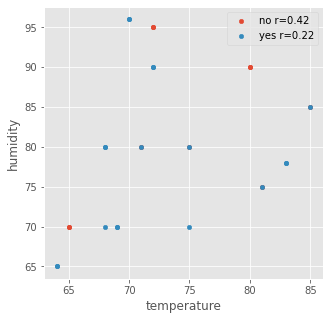

In [6]:
#create subplots: setup 1x1 Axes in one Figure 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

corr_vars = dict(pearson='r', spearman='rho', kendall='tau')
corr_method = 'pearson' #'pearson', 'spearman', 'kendall'
x_col = 'temperature'
y_col = 'humidity'

#Scatter plot by-class (groupby)
df_golf_grouped = df_golf_all.groupby('play') #for each group: tuple of (name, subsetted object)
for play, group in df_golf_grouped:
    df_corr = group.corr(method=corr_method)
    label = f'{play} {corr_vars[corr_method]}={df_corr.at[x_col, y_col].round(2)}'
    ax.scatter(x=group[x_col], y=group[y_col], label=label, s=20)
            
ax.set(xlabel=x_col, ylabel=y_col)
ax.legend()
#plt.savefig('images/golf_per_numerical_attribute_pair_by_class.png')

**Observations - Numerical:**<br>
- temperature vs. humidity by-class: no strong correlation for either 'yes' or 'no' groups

In [7]:
pd.DataFrame(df_golf_all.value_counts()).pivot_table(index='outlook', columns=['play', 'wind'], aggfunc=np.sum)

0                  
play        no         yes      
wind     False True  False True 
outlook                         
overcast   NaN   2.0   3.0   4.0
rain       NaN   3.0   4.0   2.0
sunny      4.0   1.0   3.0   2.0

**Observations - Categorical:**<br>
- outlook vs. wind by-class: only obvious fact is that non-playing non-windy days are always sunny BUT there are also playing days which are non-windy and sunny

### Math check of entropy, information gain values (first split decision)

Validating the underlying Decision Tree math learned from these excellent videos: [entropy](https://www.youtube.com/watch?v=9r7FIXEAGvs), [information gain](https://www.youtube.com/watch?v=IPkRVpXtbdY).<br>
- use just training data sample to compare with book's results

**Python:**
- Referenced code (entropy function): [IML at GitHub - Decision Trees](https://tomaszgolan.github.io/introduction_to_machine_learning/markdown/introduction_to_machine_learning_02_dt/introduction_to_machine_learning_02_dt/)
- Information gain code using **Pandas** is my own: child, parent concepts really help variable naming!
- **Pandas** makes this easy!: for **numerical attributes**, loop through all possible split points by creating temp booleans
    - try `nbinary_split` = `False` for "nunique" splits to see **overfit** case

In [8]:
from math import log

def entropy(prob_counts):
    """Calculate information entropy
    Parameters
    ----------
    prob_counts : (nd)array of counts to calculate probability
    
    Returns
    -------
    entropy :
        calculated Shannon Entropy (H)"""
        
    total = sum(prob_counts)
    return sum([-p / total * log(p / total, 2) for p in prob_counts if p !=0])

#get parent entropy and total count
n_parent = df_golf_train['play'].value_counts().sum()
h_parent = entropy(df_golf_train['play'].value_counts())

#setup for loop through attributes
columns = df_golf_train.columns.tolist()[0:-1] #all but last column 'play' (classes)
information_gain = pd.Series(index=columns, dtype=np.float64)
nbinary_split = True #False to try nunique splits (overfits!)

for column in columns:
    
    if (nbinary_split and (df_golf_train[column].dtype == (np.int64 or np.float64))):
        #check all possible numerical binary split points for minimum entropy
        h_children = 1.0 #initialize to max
        for idx, split in enumerate(df_golf_train[column].sort_values().unique()):
            df_temp = df_golf_train.copy()
            df_temp[column] = (df_temp[column] > split) #replace numeric with boolean
            
            #split on attribute inside groupby(), count, and reshape DataFrame
            df_split = df_temp.groupby(column)['play'].value_counts().unstack('play').fillna(0)
            #get each h_child (entropy) and w_child (weight) from each DataFrame row (axis=1) as Tuple
            hw_child_this_split = pd.Series(df_split.apply(lambda x : (x.sum()/n_parent, entropy(x)), axis=1))
            #do "combined entropy" calculation for all "children"
            h_children_this_split = sum([c[0]*c[1] for c in hw_child_this_split])
            
            if (h_children_this_split < h_children):
                h_children = h_children_this_split #replace IF smallest combined entropy
                
    else: #easy split on categorical
        #split on attribute inside groupby(), count, and reshape DataFrame
        df_split = df_golf_train.groupby(column)['play'].value_counts().unstack('play').fillna(0)
        
        #get each h_child (entropy) and w_child (weight) from each DataFrame row (axis=1) as Tuple
        hw_child = pd.Series(df_split.apply(lambda x : (x.sum()/n_parent, entropy(x)), axis=1))

        #do "combined entropy" calculation for all "children"
        h_children = sum([c[0]*c[1] for c in hw_child])
            
    #final Information Gain calculation for this attribute's (best for numerical) split
    information_gain[column] = h_parent - h_children

information_gain.round(3)

outlook        0.247
temperature    0.113
humidity       0.102
wind           0.048
dtype: float64

**Table 4.2 - Computing the information gain for all attributes: 75% CORRECT**
- splitting on **outlook** wins with **0.247** Information Gain
- humidity: book also uses best "numerical binary" split
- temperature: book converts to categorized 'cool', 'mild', 'hot' to get 0.029 (confirmed)

**Observations**
- setting `nbinary_split` = `False` above: can see how numeric "nunique" splits results in large Information Gains but will **overfit the training data**

**TO-DO for full ID3 algorithm => easier with Scikit-learn!:**
- recursive splitting using same algorithm
- store learned Decision Tree rules in a "graph" structure for evaluation with test data

## 2. Split data

The golf datasets came pre-split as the training sample is a commonly used sample for teaching/learning decision trees (Quinlan "ID3 algorithm" paper reference above).<br>
**Note**:
- this required some thought!: general rule seems to be to **split first before any pre-processing** so that the pre-processor is **FIT using only training data, not test data**, to avoid **data leakage** (numerous references/articles). This shouldn't matter here as the pre-processing is only one-hot encoding (missing values could still be an issue though) and not tranformative (e.g. scaling using mean or SD) but let's still stick to the rule of thumb.

### Pre-processing: encode categorical data for scikit-learn

Finally onto **scikit-learn (!!)** for ["decision trees"](https://scikit-learn.org/stable/modules/tree.html). Lots of references for Decision Tree setup steps:
1. [RealPython (general classification steps)](https://realpython.com/logistic-regression-python/#logistic-regression-in-python-with-scikit-learn-example-2)
2. [datacamp (diagram)](https://www.datacamp.com/community/tutorials/decision-tree-classification-python)
3. This article about [categorical encoding](https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/) explains the reasoning well and provides "complete example" **sk-learn** reference code

**Python - scikit-learn:**<br>
But first, we need to encode our **categorical** data columns, as per reference \[3\] above, for **both training and test data**:
- Use [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) for X (and [`LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) for Y)
    - paramater`sparse` False returns a normal ndarray: easier to inspect, otherwise "sparse matrix" (more efficient)
    - attribute `get_feature_names` very useful to reconstruct binary-encoded DataFrame columns!
    - **Remember!:** FIT with training data, then use to transform both separately
- keep in **Pandas** DataFrame format (and Series for Y label) for visibility

In [9]:
#split X_num, X_cat (attributes), Y (class) data
df_X_train = df_golf_train[df_golf_train.columns[:-1]] #all but last
s_Y_train = df_golf_train[df_golf_train.columns[-1]] #last, returns just a Series
df_X_test = df_golf_test[df_golf_test.columns[:-1]] #all but last
s_Y_test = df_golf_test[df_golf_test.columns[-1]] #last, returns just a Series

#split X numerical, categorical columns
X_num = df_X_train.select_dtypes([np.int64,np.float64]).columns
X_cat = df_X_train.select_dtypes([np.object,np.bool]).columns
Y_label = s_Y_train.name

#one-hot encode categorical attributes only
onehotenc = OneHotEncoder(sparse=False)
df_X_train_catenc = pd.DataFrame(onehotenc.fit_transform(df_X_train[X_cat]), columns=onehotenc.get_feature_names(X_cat))
df_X_test_catenc = pd.DataFrame(onehotenc.transform(df_X_test[X_cat]), columns=onehotenc.get_feature_names(X_cat))

#combine back with numerical attributes
df_X_train = pd.concat([df_X_train[X_num], df_X_train_catenc], axis=1)
df_X_test = pd.concat([df_X_test[X_num], df_X_test_catenc], axis=1)

#also need to encode the Y "label" (class) data
labelenc = LabelEncoder()
s_Y_train = pd.Series(labelenc.fit_transform(s_Y_train), name=Y_label)
s_Y_test = pd.Series(labelenc.transform(s_Y_test), name=Y_label)

#show encoded data
df_X_train.head() #shape = (14, 7)
#s_Y_train #shape = (14,)

,temperature,humidity,outlook_overcast,outlook_rain,outlook_sunny,wind_False,wind_True
0,85,85,0.0,0.0,1.0,1.0,0.0
1,80,90,0.0,0.0,1.0,0.0,1.0
2,83,78,1.0,0.0,0.0,1.0,0.0
3,70,96,0.0,1.0,0.0,1.0,0.0
4,68,80,0.0,1.0,0.0,1.0,0.0


**Observations**
- output of `OneHotEncoder` are columns of binary values for each previously categorical unique value, which means sense since we'll be possibly binary splitting on e.g., "outlook_outcast" [0.0, 1.0]

## 3. Build model

**Python - scikit-learn:**<br>
Finally creating a [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) model here, with decision math `criterion` and pruning parameters all specified when instantiating the class. Its `fit` method does all of the work from **training data X, Y**, and **scikit-learn** `plot_tree` is used to visualize the resulting tree model.
- **scikit-learn** Encoder classes provide handy ways (method above, attribute below) to get encoded column names to label `plot_tree` output
- show calculated [feature importances](https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3) of built tree
    - then compare with alternative (better) [permutation importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) (random feature shuffling) on both training and test data

[Text(372.0, 498.3, 'outlook_overcast <= 0.5\ngini = 0.459\nsamples = 14\nvalue = [5, 9]\nclass = yes'),
 Text(279.0, 407.70000000000005, 'temperature <= 77.5\ngini = 0.5\nsamples = 10\nvalue = [5, 5]\nclass = no'),
 Text(186.0, 317.1, 'temperature <= 66.5\ngini = 0.469\nsamples = 8\nvalue = [3, 5]\nclass = yes'),
 Text(93.0, 226.5, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = no'),
 Text(279.0, 226.5, 'temperature <= 70.5\ngini = 0.408\nsamples = 7\nvalue = [2, 5]\nclass = yes'),
 Text(186.0, 135.89999999999998, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]\nclass = yes'),
 Text(372.0, 135.89999999999998, 'temperature <= 73.5\ngini = 0.5\nsamples = 4\nvalue = [2, 2]\nclass = no'),
 Text(279.0, 45.299999999999955, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = no'),
 Text(465.0, 45.299999999999955, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = yes'),
 Text(372.0, 317.1, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = no'),
 Text(465.0, 407.70000000000005, 'gini = 0.0\nsamples 

,temperature,humidity,outlook_overcast,outlook_rain,outlook_sunny,wind_False,wind_True
feature_importances_,0.777778,0.0,0.222222,0.0,0.0,0.0,0.0
permutation_importances_train,0.345238,0.0,0.280952,0.0,0.0,0.0,0.0
permutation_importances_test,0.116667,0.0,0.033333,0.0,0.0,0.0,0.0


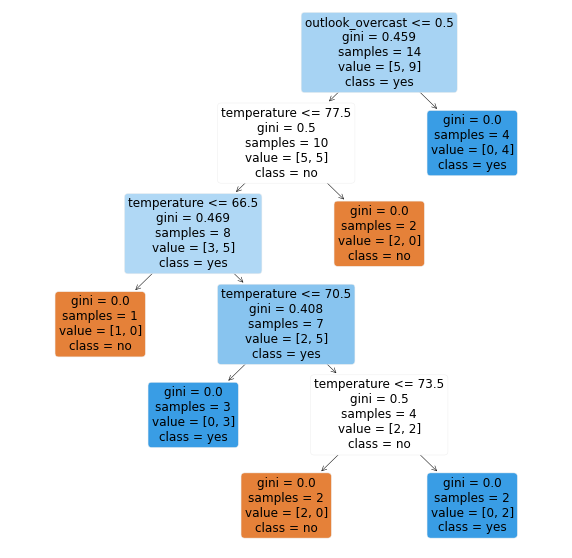

In [18]:
golf_tree = DecisionTreeClassifier(criterion='gini', #{“gini”, “entropy”}, default=”gini”
                                   #Tuning parameters below:
                                   #max_depth=4, #int, default=None ("try 3")
                                   #min_samples_split=5, #int or float, default=2 (>=2)
                                   #min_samples_leaf=1, #int or float, default=1 ("try 5")
                                   #min_impurity_decrease, #float, default=0.0
                                  )

golf_tree = golf_tree.fit(df_X_train, s_Y_train)

#plot built tree
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
plot_tree(golf_tree, ax=ax, fontsize=12, filled=True, rounded=True,
          feature_names=df_X_train.columns, class_names=labelenc.classes_)

#plt.savefig('images/golf_decision_tree_gini.png')

#Feature Importances calculation
df_golf_tree_fi = pd.DataFrame(columns=df_X_train.columns)
df_golf_tree_fi.loc['feature_importances_'] = golf_tree.feature_importances_
df_golf_tree_fi.loc['permutation_importances_train'] = permutation_importance(
    golf_tree, df_X_train, s_Y_train, n_repeats=30, random_state=0)['importances_mean']
df_golf_tree_fi.loc['permutation_importances_test'] = permutation_importance(
    golf_tree, df_X_test, s_Y_test, n_repeats=30, random_state=0)['importances_mean']
df_golf_tree_fi

**Figures 4.4/4.8 - Decision tree for golf dataset: DIFFERENT**
- because book uses ID3 algorithm (n-way splits) vs. scikit-learn [CART algorithm](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart) (binary splits)

**Notes:**
- use Microsoft Excel Data-Filter to "follow along" decision tree splits

**Observations:**
- Yes, all binary splits (CART algorithm)
- tree can repeat splitting on a numerical attribute ("feature") here, i.e. temperature
- **temperature** shows highest "feature importance" for THIS tree, being used for four splits
    - note that feature importances tend to be **inflated for numerical attributes**
    - **permutation importance** shows truer information based on how tree actually decides on both training and test data

## 4. Evaluate model

Confusion Matrix references from [RealPython](https://realpython.com/logistic-regression-python/#step-4-evaluate-the-model) and [scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix).

**Python - scikit-laern**
- `tree.score` actually combines predict and accuracy score functions, but even that is redundant with `metrics.classification_report`
- re-using useful Matplotlib code from iris_data_explore.ipynb

              precision    recall  f1-score   support

          no       0.50      0.40      0.44         5
         yes       0.70      0.78      0.74         9

    accuracy                           0.64        14
   macro avg       0.60      0.59      0.59        14
weighted avg       0.63      0.64      0.63        14



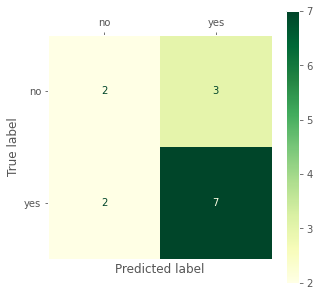

In [11]:
s_Y_predicted = pd.Series(golf_tree.predict(df_X_test), name=Y_label)
#accuracy_score(s_Y_test, s_Y_predicted)
#golf_tree.score(df_X_test, s_Y_test) #returns "score: Mean accuracy of self.predict(X) wrt. y."

#confusion_matrix(s_Y_test, s_Y_predicted) #normalize: {‘true’, ‘pred’, ‘all’}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.grid(False)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plot_confusion_matrix(golf_tree, df_X_test, s_Y_test,
                      display_labels=labelenc.classes_, cmap='YlGn', ax=ax)

print(classification_report(s_Y_test, s_Y_predicted, target_names=labelenc.classes_))

**Figure 4.9 - Performance Vector: DIFFERENT**
- axes difference in book (actual by columns) vs. sk-learn `confusion_matrix` (actual by rows)
- results difference due to algorithm (book ID3 vs sk-learn CART) and possibly numerical vs categorical "temperature"
    
**Notes:**
- confusion matrix: look for upper-left to lower-right **diagonal** for TRUE predictions (blue/red pen helps on paper!)
- intuitively, **recall** = (true of class / total **actual** of class) seems to be more important statistic but likely, application/data-specific

**Observations:**
- entire matrix accuracy is at 64.29% (9/14 correct) (same as book)
- both algorithms, but especially sk-learn **predicts Play=yes better** (78% positive recall) than Play=no (40% negative recall)

**TO-DO are other evaluation metrics:**
- ROC/AUC, lift charts

## 5. Optimize model: tuning parameters, cross-validation

I thought at least half of the work would be in improving the model through [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html) and [tuning parameters](https://scikit-learn.org/stable/modules/grid_search.html).<br>

**Then I found scikit-learn's [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)!!** It does BOTH in literally two lines (after some setup) looping through a defined (exhaustive) "parameter grid", and cross-validates each grid point, splitting the dataset "K" times into "K-1" training folds and 1 test fold.

**Python - scikit-learn:**
- Reference code: from this excellent article on [Nested CV](https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/) (only doing inner loop here!)
- Guidance on decision tree parameters grid: [Tips on practical use](https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use)
    - `DecisionTreeClassifier.get_params()` useful here to see all tunable parameters
- `GridSearchCV` has very useful attributes for quick understanding of RESULTS:
    - `best_score_`, `best_params_` for "winners"
    - `cv_results_`: get into a **Pandas** DataFrame => SAVE to CSV for Excel analysis (e.g. Data-Sort on "rank_test_score")

**TO-DO - the absolute best practice:**
- [Nested cross-validation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html), with a much larger dataset

In [12]:
#golf_tree.get_params()

# define the model (its parameters will be grid-searched)
model = DecisionTreeClassifier(random_state=1)

# define search space
param_grid = dict()
param_grid['criterion'] = ['gini', 'entropy']
param_grid['max_depth'] = np.arange(2, 6) #arange does not include last element, rounding error N/A for integers
param_grid['min_samples_split'] = np.arange(2, 6) #logically >= min_samples_leaf + 1
param_grid['min_samples_leaf'] = np.arange(1, 5)
param_grid['min_impurity_decrease'] = [0, 0.25, 0.5] #gini vs entropy

# combine training and test (n=28) one-hot-encoded X, Y data from above
df_X_all = pd.concat([df_X_train, df_X_test]) #indexes are still [0..13, 0..13] but that's OK
s_Y_all = pd.concat([s_Y_train, s_Y_test]) #indexes are still [0..13, 0..13] but that's OK

# define search
search = GridSearchCV(model, param_grid,
                      scoring='accuracy', #uses metrics.accuracy_score
                      cv=4, #golf play dataset n=28 so 4 K-folds of n=7 each
                      refit=True) #Refit an estimator using the best found parameters on the whole dataset.

# execute search
result = search.fit(df_X_all, s_Y_all)

# output results
print("Best cross-validated score:", result.best_score_) #Mean cross-validated score of the best_estimator
result.best_params_ #Parameter setting that gave the best results on the hold out data

df_cv_results = pd.DataFrame(result.cv_results_) #A dict with keys as column headers and values as columns
df_cv_results.loc[df_cv_results['rank_test_score'] == 1]
print("Min split score:", df_cv_results[['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score']].min().min())
print("Max split score:",df_cv_results[['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score']].max().max())
#df_cv_results.to_csv('./results/golf_decision_tree_gridsearchcv_results.csv', index=False) #write CSV

# get the best performing model fit on the whole training set
#best_model = result.best_estimator_

Best cross-validated score: 0.75


{'criterion': 'gini',
 'max_depth': 5,
 'min_impurity_decrease': 0,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
144,0.022960,0.027801,0.008306,0.008180,gini,5,0,1,2,"{'criterion': 'gini', 'max_depth': 5, 'min_imp...",0.857143,0.571429,0.857143,0.714286,0.75,0.118451,1
288,0.005583,0.000650,0.003675,0.000538,entropy,4,0,1,2,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",0.857143,0.571429,0.857143,0.714286,0.75,0.118451,1
336,0.005405,0.000474,0.003728,0.000260,entropy,5,0,1,2,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.857143,0.571429,0.857143,0.714286,0.75,0.118451,1


Min split score: 0.2857142857142857
Max split score: 0.8571428571428571


**Notes:**
- `.fit()` run-time comparison by param_grid size (product of parameter choices)
    - 384: 16 sec
    - 1176: 40 sec

**Observations:**
- `best_score_`:
    - **best cross-validated score of 0.7500** at least beats initial training/test split score of 0.6429
- `best_params_`:
    - is actually one of two "winners" from "rank_test_score == 1" in `cv_results_`, using the DTC min* **default values**
        - both 'gini' (max_depth=5) and 'entropy' (max_depth=4) criterion included as winners
        - assume 'entropy' max_depth=4 truly "wins" and 'entropy' max_depth=5 is unused/unneeded level of splitting
    - so results themselves are not too enlightening but am excited to try `GridSearchCV` on a real-world dataset!
- `cv_results_` analysis:
    - splits scores range from 0.2857 (4/14 correct) to 0.8571 (12/14 correct)
    - per-parameter: (focus on top and bottom results)
        - criterion: 'gini' and 'entropy' seem similar
        - max_depth: >=3 in top 10 => 2 (shallow depth) underfits
        - min_samples_leaf: all 1 for top 10 => small leaves still beneficial
        - min_impurity_decrease: bottom 24% all 0 => (low information gain) overfits in some cases

## Experiment: discretize numerical attributes

Some examples of teaching/learning decision trees with the Golf Play dataset use categories for temperature and humidity so it's worth trying to see if we can get a better tree accuracy score. Discretizing (binning):
- **temperature:** 'cool' (< 70), 'mild' (< 80), 'hot' (else)
- **humidity**: 'normal' (< 80), 'high' (else)<br>

**Python - scikit-learn**
- i) "Discretize" numerical atttributes using a Python "list comprehension"
- ii) One-hot-encoding flow from above (new `OneHotEncoder` instance) but for numerical-to-categorical attributes
- iii) Combine with encoded categorical attributes
- iv) Build new "allcat" tree
- v) Evaluate new "allcat" tree
- vi) Run `GridSearchCV` as above

[Text(418.5, 498.3, 'outlook_overcast <= 0.5\ngini = 0.459\nsamples = 14\nvalue = [5, 9]\nclass = yes'),
 Text(348.75, 407.70000000000005, 'temperature_hot <= 0.5\ngini = 0.5\nsamples = 10\nvalue = [5, 5]\nclass = no'),
 Text(279.0, 317.1, 'wind_False <= 0.5\ngini = 0.469\nsamples = 8\nvalue = [3, 5]\nclass = yes'),
 Text(139.5, 226.5, 'outlook_rain <= 0.5\ngini = 0.444\nsamples = 3\nvalue = [2, 1]\nclass = no'),
 Text(69.75, 135.89999999999998, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = yes'),
 Text(209.25, 135.89999999999998, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = no'),
 Text(418.5, 226.5, 'outlook_rain <= 0.5\ngini = 0.32\nsamples = 5\nvalue = [1, 4]\nclass = yes'),
 Text(348.75, 135.89999999999998, 'humidity_high <= 0.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]\nclass = no'),
 Text(279.0, 45.299999999999955, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = yes'),
 Text(418.5, 45.299999999999955, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = no'),
 Text(488.25,

,temperature_cool,temperature_hot,temperature_mild,humidity_high,humidity_normal,outlook_overcast,outlook_rain,outlook_sunny,wind_False,wind_True
feature_importances_,0.0,0.194444,0.0,0.155556,0.0,0.222222,0.300741,0.0,0.127037,0.0
permutation_importances_train,0.0,0.173810,0.0,0.066667,0.0,0.190476,0.285714,0.0,0.195238,0.0
permutation_importances_test,0.0,0.080952,0.0,0.085714,0.0,-0.064286,0.064286,0.0,0.097619,0.0


Numerical-to-categorical score: 0.6428571428571429


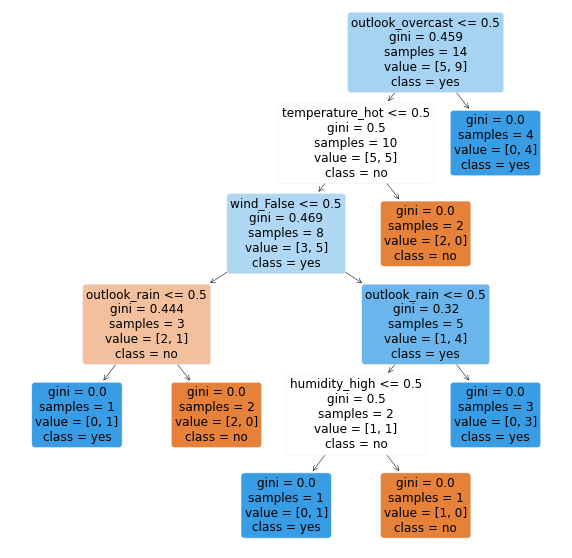

In [19]:
# i) Discretize (X_num from above)
df_X_train_num2cat = df_X_train[X_num].copy()
df_X_train_num2cat['temperature'] = ['cool' if (t < 70) else 'mild' if (t < 80) else 'hot' for t in df_X_train_num2cat['temperature']]
df_X_train_num2cat['humidity'] = ['normal' if (h < 80) else 'high' for h in df_X_train_num2cat['humidity']]
df_X_test_num2cat = df_X_test[X_num].copy()
df_X_test_num2cat['temperature'] = ['cool' if (t < 70) else 'mild' if (t < 80) else 'hot' for t in df_X_test_num2cat['temperature']]
df_X_test_num2cat['humidity'] = ['normal' if (h < 80) else 'high' for h in df_X_test_num2cat['humidity']]

# ii) One-hot-encode (numerical-to-) categorical attributes
num2cat_onehotenc = OneHotEncoder(sparse=False)
df_X_train_num2catenc = pd.DataFrame(num2cat_onehotenc.fit_transform(df_X_train_num2cat),
                                     columns=num2cat_onehotenc.get_feature_names(X_num))
df_X_test_num2catenc = pd.DataFrame(num2cat_onehotenc.transform(df_X_test_num2cat),
                                     columns=num2cat_onehotenc.get_feature_names(X_num))

# iii) Combine back with previously encoded categorical attributes
df_X_train_allcat = pd.concat([df_X_train_num2catenc, df_X_train_catenc], axis=1)
df_X_test_allcat = pd.concat([df_X_test_num2catenc, df_X_test_catenc], axis=1)

# iv) Build new tree
allcat_golf_tree = DecisionTreeClassifier(criterion='gini', random_state=2)
allcat_golf_tree = allcat_golf_tree.fit(df_X_train_allcat, s_Y_train)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
plot_tree(allcat_golf_tree, ax=ax, fontsize=12, filled=True, rounded=True,
          feature_names=df_X_train_allcat.columns, class_names=labelenc.classes_)
#plt.savefig('images/golf_decision_tree_gini_allcat.png')

#Feature Importances calculation
df_allcat_golf_tree_fi = pd.DataFrame(columns=df_X_train_allcat.columns)
df_allcat_golf_tree_fi.loc['feature_importances_'] = allcat_golf_tree.feature_importances_
df_allcat_golf_tree_fi.loc['permutation_importances_train'] = permutation_importance(
    allcat_golf_tree, df_X_train_allcat, s_Y_train, n_repeats=30, random_state=0)['importances_mean']
df_allcat_golf_tree_fi.loc['permutation_importances_test'] = permutation_importance(
    allcat_golf_tree, df_X_test_allcat, s_Y_test, n_repeats=30, random_state=0)['importances_mean']
df_allcat_golf_tree_fi

# v) Evaluate new tree
print ("Numerical-to-categorical score:", allcat_golf_tree.score(df_X_test_allcat, s_Y_test))

**Observations (numerical-to-categorical):**
- same accuracy score of 64.29% (9/14 correct)
- the tree does use different attributes now
    - but non-deterministic per-run because: *if the improvement of the criterion is identical for several splits and one split has to be selected at random*
        - solution: set `random_state` to interger when instantiating `DecisionTreeClassifier`
    - after converting numerical to categorical, relative feature importances are indeed more evenly distribtued

In [14]:
# vi) Run GridSearchCV (assume s_Y_all, param_grid from above)
df_X_allcat = pd.concat([df_X_train_allcat, df_X_test_allcat])
model_allcat = DecisionTreeClassifier(random_state=1)
search_allcat = GridSearchCV(model_allcat, param_grid,
                      scoring='accuracy', #uses metrics.accuracy_score
                      cv=4, #golf play dataset n=28 so 4 K-folds of n=7 each
                      refit=True) #Refit an estimator using the best found parameters on the whole dataset.
result_allcat = search_allcat.fit(df_X_allcat, s_Y_all)
print("Best cross-validated score:", result_allcat.best_score_) #Mean cross-validated score of the best_estimator
result_allcat.best_params_
df_cv_results_allcat = pd.DataFrame(result_allcat.cv_results_) #A dict with keys as column headers and values as columns
df_cv_results_allcat.loc[df_cv_results_allcat['rank_test_score'] == 1]

Best cross-validated score: 0.75


{'criterion': 'gini',
 'max_depth': 4,
 'min_impurity_decrease': 0,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
96,0.004378,0.000061,0.002967,0.000075,gini,4,0,1,2,"{'criterion': 'gini', 'max_depth': 4, 'min_imp...",0.714286,0.571429,0.857143,0.857143,0.75,0.118451,1
144,0.004554,0.000509,0.003367,0.000598,gini,5,0,1,2,"{'criterion': 'gini', 'max_depth': 5, 'min_imp...",0.714286,0.714286,0.714286,0.857143,0.75,0.061859,1
288,0.004287,0.000032,0.002890,0.000038,entropy,4,0,1,2,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",0.714286,0.571429,0.857143,0.857143,0.75,0.118451,1
336,0.007193,0.002513,0.003814,0.000451,entropy,5,0,1,2,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.714286,0.714286,0.714286,0.857143,0.75,0.061859,1


**Observations (numerical-to-categorical):**
- `GridSearchCV` results:
    - best scores are same as for numerical attributes at 75%
    - best parameters are also gini and entropy with DTC min* defaults (but gini has a winner with max_depth=4)

## Conclusions

### Decision tree learnings

**Classification process**
- learned just as much if not more about the classification process than the algorithm itself: pre-processing data, tuning parameters and cross-validation
- what scikit-learn offers to make that process efficient is impressive: one-liners to build, evaluate, and even tuneXcross-validate the model, useful data structures to evaluate results and setup parameter grids
- Confusion Matrix is a great first step to evaluation; valuable to understand meanings of accuracy, recall, and precision according to context of dataset

**Nuances, i.e. where all of the fun is!**
- one-hot-encoding needed for categorical variables (scikit-learn); effectively turns each category into a binary (makes sense for CART's binary trees)
- split data before pre-processing to avoid data leakage
- (not tried here: nested cross-validation to evaluate truly "held-out" test data against "best" model)

**Golf Play dataset**
- you'll probably play golf on overcast days (78% from data exploration) and this makes Play=yes much more predictable (78% recall) than Play=no using a Decision Tree on this very small dataset

**Decision Tree**
- recognizing that this small dataset is limited for conclusions:
    - Gini and Entropy-based trees gave similar results
    - max_depth can't be too shallow or else underfits
    - nothing conclusive about min_samples_leaf (as default 1 gave best score), learn more from other datasets